## 1. Install and Import Dependencies

In [1]:
!pip install easyocr
!pip install imutils

  Using cached Pillow-8.2.0-cp39-cp39-win_amd64.whl (2.2 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [2]:
import pandas as pd
import time
import datetime
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr


## 2. Read in Image, Grayscale and Blur

In [4]:
from google.colab import drive
drive.mount('/content/drive')


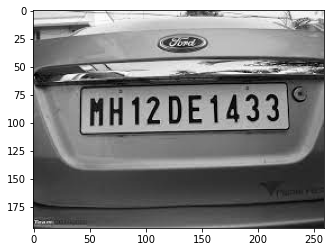

In [6]:
img = cv2.imread('/content/drive/MyDrive/Capstone-cv2/20.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 3. Apply filter and find edges for localization

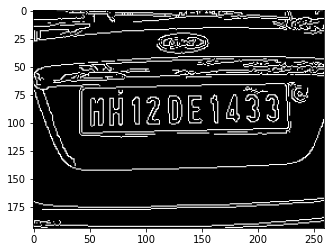

In [7]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 4. Find Contours and Apply Mask

In [8]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [9]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [10]:
location

array([[[225,  67]],

       [[ 46,  69]],

       [[ 43, 108]],

       [[225, 109]]], dtype=int32)

In [11]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

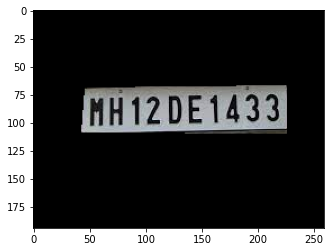

In [12]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [13]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

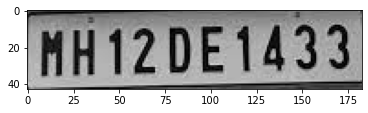

In [14]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 5. Use Easy OCR To Read Text

In [15]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 1], [183, 1], [183, 43], [0, 43]], 'MHIZ DE1433', 0.5989960051496562)]

In [16]:
# result[1][-2]

## 6. Result

In [17]:
text = result[0][-2]
text=''.join(e for e in text if e.isalnum())
text

'MHIZDE1433'

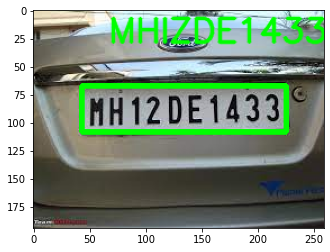

In [18]:
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][1], approx[2][0][1]-80), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [19]:
states={"AN":"Andaman and Nicobar","AP":"Andhra Pradesh","AR":"Arunachal Pradesh","AS":"Assam","BR":"Bihar","CH":"Chandigarh","DN":"Dadra and Nagar Haveli","DD":"Daman and Diu","DL":"Delhi","GA":"Goa","GJ":"Gujarat",
"HR":"Haryana","HP":"Himachal Pradesh","JK":"Jammu and Kashmir","KA":"Karnataka","KL":"Kerala","LD":"Lakshadweep","MP":"Madhya Pradesh","MH":"Maharashtra","MN":"Manipur","ML":"Meghalaya","MZ":"Mizoram","NL":"Nagaland","OD":"Odissa","PY":"Pondicherry","PN":"Punjab","RJ":"Rajasthan","SK":"Sikkim","TN":"TamilNadu","TR":"Tripura","UP":"Uttar Pradesh", "WB":"West Bengal","CG":"Chhattisgarh","TS":"Telangana","JH":"Jharkhand","UK":"Uttarakhand"}

In [20]:
#Get the State information
stat = text[0:2]
print('Car Belongs to',states[stat])

Car Belongs to Maharashtra


In [21]:
num=int(text[-2:])
current_time = datetime.datetime.now() 
day=current_time.day

raw_data = {'date': [current_time],'v_number': [text]}
df = pd.DataFrame(raw_data, columns = ['date', 'v_number'])


In [22]:
if ((num % 2) == 0 and (day % 2) == 0) or ((num % 2) != 0 and (day % 2) != 0) :
    print("Vehicle RC number is allowed")

else:
    print("Vehicle RC last four digit number is :" ,(int(text[-4:])), "and day:" ,day)
    print("Vehicle RC number is not allowed today")
    df.append(raw_data,ignore_index=True)
  # df.to_csv('Vehicle_data.csv', mode='a', index=False, header=False)

Vehicle RC last four digit number is : 1433 and day: 4
Vehicle RC number is not allowed today


## 7. Result append in CSV

In [23]:
df

,date,v_number
0,2021-12-04 20:47:21.206674,MHIZDE1433


In [24]:
df.to_csv('Vehicle_data.csv')